In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### 데이터로드

In [ ]:
# 엑셀명 : relay-foods
# 시트명 : Purchase Data - Full Study
# 구매데이터
df = pd.read_excel('/content/drive/MyDrive/데이터분석스쿨2기/share/12.데이터활용및과학방법론-12/relay-foods.xlsx',
        sheet_name='Purchase Data - Full Study')
df.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


In [ ]:
df.shape

(2891, 7)

### 데이터 준비

- 년월단위로 파생변수 구성
    - OrderDate (주문한날)
        - 2009-01-11 -> 2009-01
    - 월단위로 코호트 집단 구성
        - 월단위 주문월 컬럼 추가
        - OrderPeroid 파생변수 생성

In [ ]:
# 실습 1분 OrderPeroid 파생변수 생성
df['OrderPeroid'] = df.OrderDate.apply( lambda x:x.strftime('%Y-%m'))
df.head(2)

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderPeroid
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01


In [ ]:
# 코로트 집단의 대상이 되는 집계 단위 확인
df['OrderPeroid'].unique()
# 15개월치 기준으로 그룹이 구성될수 있다

array(['2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06',
       '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12',
       '2010-01', '2010-02', '2010-03'], dtype=object)

In [ ]:
df.set_index('UserId', inplace=True)
df.head(2)

,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeroid
UserId,,,,,,,
47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01
47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01


In [ ]:
df.shape

(2891, 7)

In [ ]:
# 사용자별 첫 구매월(Day 0)
# (모든 OrderDate=> 사용자별로 가장 초기 주문날짜, 최소값) 추출

# 1. 고객별 집계 -> 최초 구매일 기준(년-월) 집계
#.   -> df구조상 : 컬럼 X, 인덱스 대상으로 집계
#    인덱스 기준으로 집계 => level 지정해서 처리 가능
#.   UserId 기준으로 집계하는것과 동일 현상
df.groupby(level = 0)['OrderDate'].min() \
    .apply( lambda x:x.strftime('%Y-%m'))

# 757명에 대한 초기 주문 날자 획득

UserId
47        2009-01
95        2009-03
98        2009-01
112       2009-01
141       2009-11
           ...   
393616    2010-03
394290    2010-03
394346    2010-03
395039    2010-03
396551    2010-03
Name: OrderDate, Length: 757, dtype: object

In [ ]:
df.groupby(level = 0)['OrderPeroid'].min()

UserId
47        2009-01
95        2009-03
98        2009-01
112       2009-01
141       2009-11
           ...   
393616    2010-03
394290    2010-03
394346    2010-03
395039    2010-03
396551    2010-03
Name: OrderPeroid, Length: 757, dtype: object

In [ ]:
# 2. 파생변수(CohortGroup) 생성 -> 최초 구매일 Day-0 기반 년-월을 값으로 가진
# OrderDate를 기반으로 생성
# 1분 진행
# level = 0 => 사용자 아이디가 현재 인덱스
# => 사용자별, 구매일별 최소값 추출 ->년월->코호트그룹값 설정
df['CohortGroup'] = df.groupby(level = 0)['OrderDate'].min() \
    .apply( lambda x:x.strftime('%Y-%m'))
df.head(2)

,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeroid,CohortGroup
UserId,,,,,,,,
47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01,2009-01


In [ ]:
# UserId를 다시 컬럼으로 복구
df.reset_index(inplace=True)
'''
    1. 유저별 최초 구매한 년-월을 추출
        -> 유저의 모든 구매 데이터에서 가작 작은값에서 추출 -> 이값이 해당 코호트 그룹
        - CohortGroup
    2. 유저별로 매월 구매한 내역, 년-월 정보는 유지
        - OrderPeroid
    3. 정리
        - raw 데이터 기반
            - 파생변수 2개 (코호트 그룹값, 구매년월정보)

    QnA
        - 고객 구매 데이터별 코호트
        - 그룹값(년-월단위), 구매정보(년-월)을 다르게 구성하여 최종 결과물은 동일하게
'''
df

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeroid,CohortGroup
0,47,262,2009-01-11,50.6700,TRQKD,2,2009-01-12,2009-01,2009-01
1,47,278,2009-01-20,26.6000,4HH2S,3,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,38.7100,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,53.3800,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,14.2800,FFYHD,2,2009-02-09,2009-02,2009-01
...,...,...,...,...,...,...,...,...,...
2886,393616,3220,2010-03-08,60.0155,AWNXG,15,2010-03-08,2010-03,2010-03
2887,394290,3192,2010-03-07,45.4300,AKGQT,12,2010-03-10,2010-03,2010-03
2888,394346,3193,2010-03-07,14.2100,2B47R,15,2010-03-08,2010-03,2010-03
2889,395039,3207,2010-03-08,34.6200,H6E23,4,2010-03-08,2010-03,2010-03


In [ ]:
# 데이터 확인
# 조건을 이용한 데이터 추출 -> 블리언 인덱싱, 쿼리수행
# 소속한 코호트 그룹값와 다른 주문날을 가진 데이터를 추출하시오
df.query('OrderPeroid != CohortGroup')

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeroid,CohortGroup
2,47,294,2009-02-03,38.7100,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,53.3800,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,14.2800,FFYHD,2,2009-02-09,2009-02,2009-01
5,47,321,2009-02-17,29.5000,HA5R3,3,2009-02-17,2009-02,2009-01
6,47,333,2009-02-23,18.9100,RSXQG,2,2009-02-23,2009-02,2009-01
...,...,...,...,...,...,...,...,...,...
2847,369133,3094,2010-03-01,17.7900,SAPNJ,7,2010-03-04,2010-03,2010-02
2849,370402,3119,2010-03-02,37.3552,ZLBJ5,9,2010-03-03,2010-03,2010-02
2862,376775,3227,2010-03-08,43.7000,Q53K9,9,2010-03-10,2010-03,2010-02
2868,380119,3224,2010-03-08,56.7115,ZRWZB,15,2010-03-08,2010-03,2010-02


#### 코호트그룹별 재구매년월별 기준 고객수, 주문수, 총매출합계 구성

- 인덱스 기준
    - CohortGroup, OrderPeroid
- 컬럼 기준
    - 고객수(고유한), 주문수(고유한), 총매출합계(np.sum)
    - 함수적용 -> agg..
    

In [ ]:
# 실습 3분
# 코호트 그룹과 동일월, 다른월도 존재 => 집계기준
group = df.groupby( ['CohortGroup', 'OrderPeroid'] )

# 함수를 적용하여 컬럼을 구성
# 월단위 그룹 => 일단위 데이터들이 묶이게된다 => 묶인 데이터 =>
cohort_df = group.agg({
    # 컬럼명:함수(데이터를 어떻게 처리해서 입력)
    'UserId' : pd.Series.nunique, # 고유한값만유지
    'OrderId': pd.Series.nunique, # 고유한값만유지
    'TotalCharges' : np.sum # 총매출(그룹을 묶은 단위로)
})

cohort_df
# UserId, OrderId => 고유한 개수
# TotalCharges => 월별 구매 총액

UserId  OrderId  TotalCharges
CohortGroup OrderPeroid                               
2009-01     2009-01          22       30     1850.2550
            2009-02           8       25     1351.0650
            2009-03          10       26     1357.3600
            2009-04           9       28     1604.5000
            2009-05          10       26     1575.6250
...                         ...      ...           ...
2010-01     2010-02          50      101     8453.1039
            2010-03          26       31     2238.6461
2010-02     2010-02         100      139     7374.7108
            2010-03          19       19      945.9633
2010-03     2010-03          24       26     1099.5471

[119 rows x 3 columns]

In [ ]:
'''
    - 해석
        - 2009년 2월 첫구매한 고객수는 15명, 주문수 15건, 매출액 666.3100
            - 이후 3월 3명만, 4월에는 5명, 5월에는 1명 등 고객유지율은 하락
            - 고객유지율보다 주문수가 더 많음 => 1명의 고객이 여러건을 주문
        - 1월에 구매행동을 보인 15명에 대한, 구매 유무만 체크한표
            - 15명이 특정 고객이 연속해서 매월 구매하고 있다라고 말할수 없음
                - 분석 내용에는 없는 내용
'''
cohort_df.query( " CohortGroup=='2009-02' " )
# 코호트 그룹 2009-02에 대한 조회 내용

UserId  OrderId  TotalCharges
CohortGroup OrderPeroid                               
2009-02     2009-02          15       15      666.3100
            2009-03           3        8      501.6100
            2009-04           5       10      968.7800
            2009-05           1        2       53.3600
            2009-06           4        9      758.5200
            2009-07           4       11      667.1000
            2009-08           4        6      314.1752
            2009-09           5       12      567.5057
            2009-10           5        7      328.2800
            2009-11           4        6      738.9359
            2009-12           3        5      263.1971
            2010-01           3        5      550.0098
            2010-02           5        9      734.7613

In [ ]:
# 컬럼명을 의도에 맞게 조정
cohort_df.rename(columns={ \
    'UserId' :'TotalUsers', \
    'OrderId':'TotalOrders'
}, inplace=True)

In [ ]:
cohort_df.query( " CohortGroup=='2010-01' " )
# 유지율이 매월 50%씩 감소 -> 아직 특정값에 수렴하는것은 보이지 않음
# 한 유저가 여러개를 구매하는 유형의 고객이 2010-03에서는 대폭 줄어듬
# 데이터가 더 존재해야 판단 가능

TotalUsers  TotalOrders  TotalCharges
CohortGroup OrderPeroid                                       
2010-01     2010-01              95          156     9677.9032
            2010-02              50          101     8453.1039
            2010-03              26           31     2238.6461

In [ ]:
# OrderPeroid를 기준으로 코호트 그릅당 (M+)1, (M+)2, ... -> 설정
# 코호트 그룹별로 상이한 기간값 가진다 -> 시각화 -> 삼각형 형태가 나옴
cohort_df.head(20)

TotalUsers  TotalOrders  TotalCharges
CohortGroup OrderPeroid                                       
2009-01     2009-01              22           30     1850.2550
            2009-02               8           25     1351.0650
            2009-03              10           26     1357.3600
            2009-04               9           28     1604.5000
            2009-05              10           26     1575.6250
            2009-06               8           26     1384.8400
            2009-07               8           24     1750.8400
            2009-08               7           21     1426.5714
            2009-09               7           24     1964.2755
            2009-10               7           13      860.3292
            2009-11               7           21     1821.8153
            2009-12               8           22     2152.1165
            2010-01              11           25     2084.2236
            2010-02               7           19     2068.7771
            2010-03               6           12     1504.3325
2009-02     2009-02              15           15      666.3100
            2009-03               3            8      501.6100
            2009-04               5           10      968.7800
            2009-05               1            2       53.3600
            2009-06               4            9      758.5200

In [ ]:
# OrderPeroid를 기준으로 코호트 그릅당 (M+)1, (M+)2, ... -> 설정
# 파생변수 CohortPeroid를 cohort_df의 파생변수로 추가
# 실습 : 3분
# 코호트 그릅당 집계 => 해당 데이터들의 개수를 대상 연속수 생성 (0,1, 2, 3)+1
# => 파생변수에 세팅 => 집계가 모두 끝나면 하나의 피처로 생성된다
group = cohort_df.groupby( level=0 )
group.groups

{'2009-01': [('2009-01', '2009-01'), ('2009-01', '2009-02'), ('2009-01', '2009-03'), ('2009-01', '2009-04'), ('2009-01', '2009-05'), ('2009-01', '2009-06'), ('2009-01', '2009-07'), ('2009-01', '2009-08'), ('2009-01', '2009-09'), ('2009-01', '2009-10'), ('2009-01', '2009-11'), ('2009-01', '2009-12'), ('2009-01', '2010-01'), ('2009-01', '2010-02'), ('2009-01', '2010-03')], '2009-02': [('2009-02', '2009-02'), ('2009-02', '2009-03'), ('2009-02', '2009-04'), ('2009-02', '2009-05'), ('2009-02', '2009-06'), ('2009-02', '2009-07'), ('2009-02', '2009-08'), ('2009-02', '2009-09'), ('2009-02', '2009-10'), ('2009-02', '2009-11'), ('2009-02', '2009-12'), ('2009-02', '2010-01'), ('2009-02', '2010-02')], '2009-03': [('2009-03', '2009-03'), ('2009-03', '2009-04'), ('2009-03', '2009-05'), ('2009-03', '2009-06'), ('2009-03', '2009-07'), ('2009-03', '2009-08'), ('2009-03', '2009-09'), ('2009-03', '2009-10'), ('2009-03', '2009-11'), ('2009-03', '2009-12'), ('2009-03', '2010-01'), ('2009-03', '2010-02'), (

In [ ]:
# 집계된 df가 apply()에 통으로 전달
def make_preiod( df ):
    '''
        df : 코호트 그룹별 데이터가 전달 > DataFrame 형식
    '''
    # 파생변수 생성
    # 0부터할지, 1부터할지는 컨셉
    df['CohortPeroid'] = np.arange( df.shape[0] ) + 1 # 1부터 세팅되게
    return df

temp = cohort_df.groupby( level=0 ).apply( make_preiod )
temp

TotalUsers  TotalOrders  TotalCharges  \
CohortGroup CohortGroup OrderPeroid                                          
2009-01     2009-01     2009-01              22           30     1850.2550   
                        2009-02               8           25     1351.0650   
                        2009-03              10           26     1357.3600   
                        2009-04               9           28     1604.5000   
                        2009-05              10           26     1575.6250   
...                                         ...          ...           ...   
2010-01     2010-01     2010-02              50          101     8453.1039   
                        2010-03              26           31     2238.6461   
2010-02     2010-02     2010-02             100          139     7374.7108   
                        2010-03              19           19      945.9633   
2010-03     2010-03     2010-03              24           26     1099.5471   

                                     CohortPeroid  
CohortGroup CohortGroup OrderPeroid                
2009-01     2009-01     2009-01                 1  
                        2009-02                 2  
                        2009-03                 3  
                        2009-04                 4  
                        2009-05                 5  
...                                           ...  
2010-01     2010-01     2010-02                 2  
                        2010-03                 3  
2010-02     2010-02     2010-02                 1  
                        2010-03                 2  
2010-03     2010-03     2010-03                 1  

[119 rows x 4 columns]

In [ ]:
# 추가된 피처만 확인 -> 코호트 그룹별로 1~ 내용 확인
temp['CohortPeroid'].values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9,  1,  2,
        3,  4,  5,  6,  7,  8,  1,  2,  3,  4,  5,  6,  7,  1,  2,  3,  4,
        5,  6,  1,  2,  3,  4,  5,  1,  2,  3,  4,  1,  2,  3,  1,  2,  1])

In [ ]:
cohort_df['CohortPeroid'] = temp['CohortPeroid'].values

In [ ]:
# CohortGroup이 레벨에 2개가 발생(계산상 발생)
cohort_df.query( " CohortGroup=='2010-01' " )

TotalUsers  TotalOrders  TotalCharges  CohortPeroid
CohortGroup OrderPeroid                                                     
2010-01     2010-01              95          156     9677.9032             1
            2010-02              50          101     8453.1039             2
            2010-03              26           31     2238.6461             3

#### 최종형태 구성

In [ ]:
cohorts = cohort_df.copy(True)
cohorts.head(2)

TotalUsers  TotalOrders  TotalCharges  CohortPeroid
CohortGroup OrderPeroid                                                     
2009-01     2009-01              22           30      1850.255             1
            2009-02               8           25      1351.065             2

In [ ]:
cohorts.reset_index(inplace=True)
cohorts.head(2)

,CohortGroup,OrderPeroid,TotalUsers,TotalOrders,TotalCharges,CohortPeroid
0,2009-01,2009-01,22,30,1850.255,1
1,2009-01,2009-02,8,25,1351.065,2


In [ ]:
# 인덱스 새로 구성
# 코호트 그룹, 기간을 묶어서 구성
cohorts.set_index(['CohortGroup','CohortPeroid'], inplace=True)
cohorts
# 각 코호트 그룹내에서 특정 유저는 특정 기간에 2회이상 구매 내역이 존재함

OrderPeroid  TotalUsers  TotalOrders  TotalCharges
CohortGroup CohortPeroid                                                   
2009-01     1                2009-01          22           30     1850.2550
            2                2009-02           8           25     1351.0650
            3                2009-03          10           26     1357.3600
            4                2009-04           9           28     1604.5000
            5                2009-05          10           26     1575.6250
...                              ...         ...          ...           ...
2010-01     2                2010-02          50          101     8453.1039
            3                2010-03          26           31     2238.6461
2010-02     1                2010-02         100          139     7374.7108
            2                2010-03          19           19      945.9633
2010-03     1                2010-03          24           26     1099.5471

[119 rows x 4 columns]

#### Retention (고객 유지율(%))

- (코호트 그룹별 CohortPeroid별 해당 인원	) / (코호트 그룹별 첫 구매월 기준 회원수) * 100
    - 코호트 그룹별 첫 구매월 기준 회원수
        - 2009-01 그룹 => 22
    - 코호트 그룹별 CohortPeroid별 해당 인원
        - 2009-01 그룹 - CohortPeroid 2라면 => 8

In [ ]:
# 코호트 그룹별 첫 구매월(Month 0) 기준 회원수 획득
# cohorts 대상
'''
2009-01 22
...
2010-02 100
2010-03 24
'''
# 실습 1분
# 총회원수 컬럼기준 데이터에 대한 코호트그룹별 집계 -> 최대값, 첫번째
cohort_group_first_users = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_first_users

CohortGroup
2009-01     22
2009-02     15
2009-03     13
2009-04     39
2009-05     50
2009-06     32
2009-07     50
2009-08     31
2009-09     37
2009-10     54
2009-11    130
2009-12     65
2010-01     95
2010-02    100
2010-03     24
Name: TotalUsers, dtype: int64

- cohorts 데이터프레임을 조정
    - 컬럼 파트 CohortPeroid,
    - 인덱스 파트 CohortGroup
    <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*DYDOif_qBEgtWfFKUDSf0Q.png">

In [ ]:
cohorts.head(2)

OrderPeroid  TotalUsers  TotalOrders  TotalCharges
CohortGroup CohortPeroid                                                   
2009-01     1                2009-01          22           30      1850.255
            2                2009-02           8           25      1351.065

In [ ]:
# unstack( 인덱스레벨값 ) => 인덱스레벨값이 컬럼으로 이동
cohorts['TotalUsers'].unstack(1)

CohortPeroid,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
CohortGroup,,,,,,,,,,,,,,,
2009-01,22.0,8.0,10.0,9.0,10.0,8.0,8.0,7.0,7.0,7.0,7.0,8.0,11.0,7.0,6.0
2009-02,15.0,3.0,5.0,1.0,4.0,4.0,4.0,5.0,5.0,4.0,3.0,3.0,5.0,NaN,NaN
2009-03,13.0,4.0,5.0,4.0,1.0,2.0,2.0,3.0,2.0,1.0,3.0,2.0,1.0,NaN,NaN
2009-04,39.0,13.0,10.0,13.0,6.0,7.0,4.0,6.0,2.0,4.0,3.0,2.0,NaN,NaN,NaN
2009-05,50.0,13.0,12.0,5.0,4.0,6.0,3.0,5.0,5.0,4.0,3.0,NaN,NaN,NaN,NaN
2009-06,32.0,15.0,9.0,6.0,7.0,5.0,3.0,3.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN
2009-07,50.0,23.0,13.0,10.0,11.0,10.0,11.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,31.0,11.0,9.0,7.0,6.0,8.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,37.0,15.0,14.0,8.0,13.0,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 리텐션 획득
# cohort_group_first_users 나누기 진행시 기준값이 상이해서 unstack(0) 처리후 축변경
retention_df = cohorts['TotalUsers'].unstack(0) / cohort_group_first_users
retention_df

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeroid,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.0
2,0.363636,0.200000,0.307692,0.333333,0.26,0.46875,0.46,0.354839,0.405405,0.314815,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,0.28125,0.26,0.290323,0.378378,0.222222,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,0.18750,0.20,0.225806,0.216216,0.240741,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,0.21875,0.22,0.193548,0.351351,0.240741,0.100000,NaN,NaN,NaN,NaN
6,0.363636,0.266667,0.153846,0.179487,0.12,0.15625,0.20,0.258065,0.243243,0.129630,NaN,NaN,NaN,NaN,NaN
7,0.363636,0.266667,0.153846,0.102564,0.06,0.09375,0.22,0.129032,0.216216,NaN,NaN,NaN,NaN,NaN,NaN
8,0.318182,0.333333,0.230769,0.153846,0.10,0.09375,0.14,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.318182,0.333333,0.153846,0.051282,0.10,0.31250,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 고객 유지율 시각화

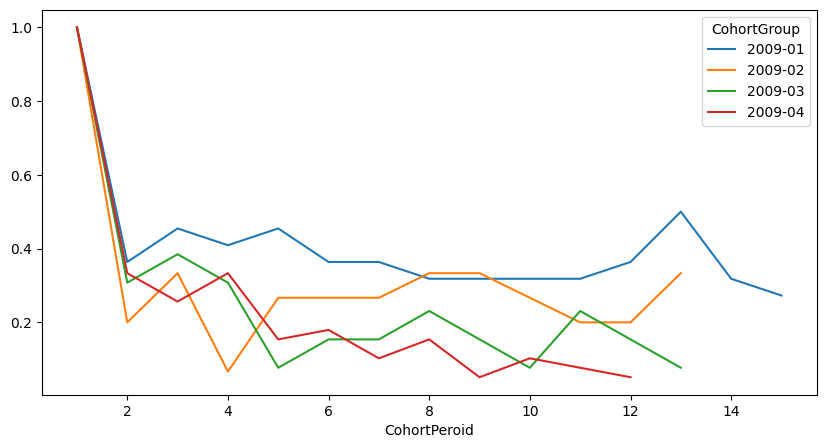

In [ ]:
retention_df[ retention_df.columns[:4] ].plot(figsize=(10,5));
# 2009-01 코호트 그룹이 상대적으로 다른 그룹에 비해 유지율이 높다 (30% 내외로 유지하는것으로보임)

- 전통적 코호트 차트

In [ ]:
'''
    - 인덱스 : 코호트 그룹
    - 컬럼 : 기간
'''
retention_df.T

CohortPeroid,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
CohortGroup,,,,,,,,,,,,,,,
2009-01,1.0,0.363636,0.454545,0.409091,0.454545,0.363636,0.363636,0.318182,0.318182,0.318182,0.318182,0.363636,0.500000,0.318182,0.272727
2009-02,1.0,0.200000,0.333333,0.066667,0.266667,0.266667,0.266667,0.333333,0.333333,0.266667,0.200000,0.200000,0.333333,NaN,NaN
2009-03,1.0,0.307692,0.384615,0.307692,0.076923,0.153846,0.153846,0.230769,0.153846,0.076923,0.230769,0.153846,0.076923,NaN,NaN
2009-04,1.0,0.333333,0.256410,0.333333,0.153846,0.179487,0.102564,0.153846,0.051282,0.102564,0.076923,0.051282,NaN,NaN,NaN
2009-05,1.0,0.260000,0.240000,0.100000,0.080000,0.120000,0.060000,0.100000,0.100000,0.080000,0.060000,NaN,NaN,NaN,NaN
2009-06,1.0,0.468750,0.281250,0.187500,0.218750,0.156250,0.093750,0.093750,0.312500,0.093750,NaN,NaN,NaN,NaN,NaN
2009-07,1.0,0.460000,0.260000,0.200000,0.220000,0.200000,0.220000,0.140000,0.140000,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,1.0,0.354839,0.290323,0.225806,0.193548,0.258065,0.129032,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,1.0,0.405405,0.378378,0.216216,0.351351,0.243243,0.216216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
retention_df.T.isnull()

CohortPeroid,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
CohortGroup,,,,,,,,,,,,,,,
2009-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2009-02,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
2009-03,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
2009-04,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True
2009-05,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True
2009-06,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True
2009-07,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
2009-08,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True
2009-09,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True


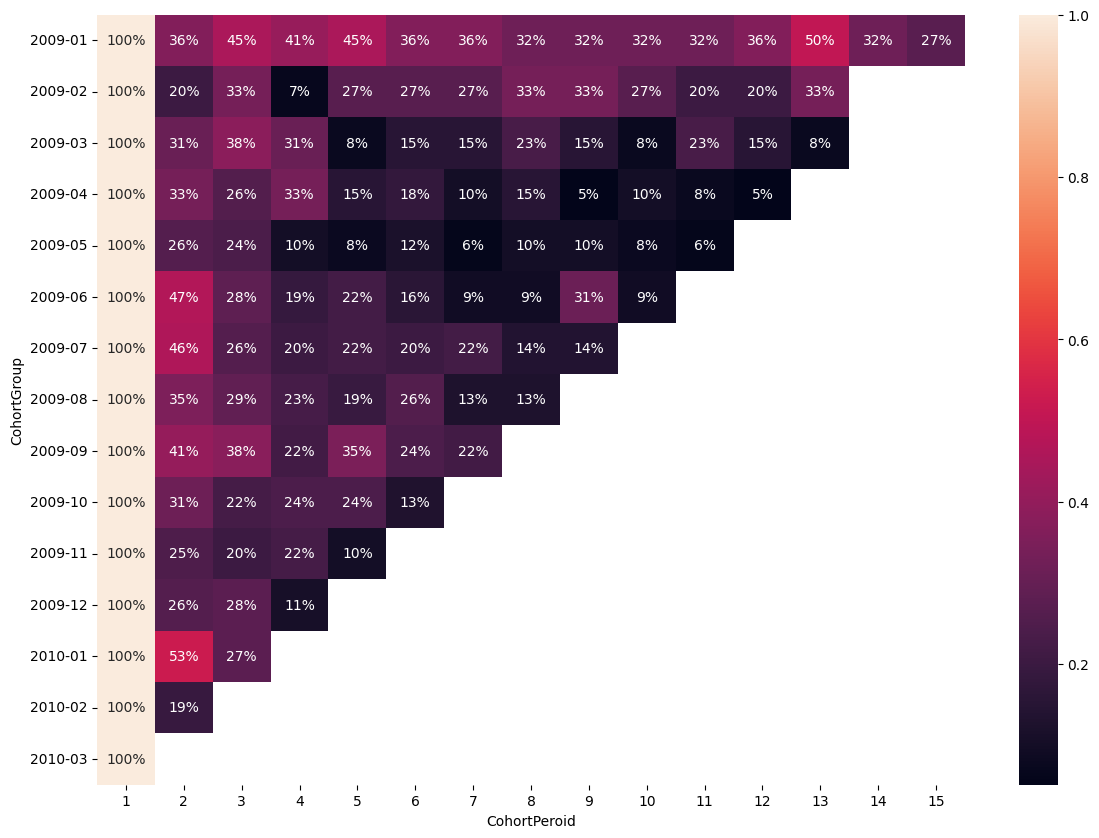

In [ ]:
# 밀도 기반 유지율이 낮으면(혹은 높으면) 진하게 표시, 영역에 유지율 표시
# 히트맵
import seaborn as sns

# annot 표시때 겹쳐지므로 -> 차트 크기 키움
plt.figure( figsize=( 14, 10))

# mask = retention_df.T.isnull() : True인 구간은 표시하지 않음
sns.heatmap( retention_df.T, annot=True, fmt='.0%' );
해석 = '''
    - 대각선
        - 2009-02 코호트 그룹은 기간 14월후에 유지율이 0% 됨 -> 이상징후 발견
        - 2009-01, 2010-01(기간을 좀더 봐야 할듯) 그룹은 27% 정도 수준으로 계속 유지
        - 2009-01 그룹이 특별한 이벤트가 있엇는지 체크
            - 다른 그룹의 2~3배 유지
    - 수평
        - 2010-01는 매월 50%씩 유지율이 감소
            - 타 그룹에 비하면 그 감소율이 상대적으로 높은지(혹은 낮은지 ) 점검
        - 2009-04 그룹은
            - 2개월차에 1/3, 4개월 50%하락 4개월 후 50%하락의 패턴이 보임(참고 대략적으로기술)
    - 수직
        - 각 기간별
            - 코호트 그룹간 유지율 하락 추세를 비교
                - 기간 2, 기간 3일때 어떤 그룹아 상대적으로 많이 하락, 이미 안정권으로 유지되고 잇는지 등등 점검
                - 이런 특징점들을 기반으로 고객관리 진행(파악등)

'''

- 전통적 코호트 차트 + 구매총액

In [ ]:
cohorts['TotalCharges'].unstack(0).T.fillna(0).astype('int')

CohortPeroid,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
CohortGroup,,,,,,,,,,,,,,,
2009-01,1850,1351,1357,1604,1575,1384,1750,1426,1964,860,1821,2152,2084,2068,1504
2009-02,666,501,968,53,758,667,314,567,328,738,263,550,734,0,0
2009-03,806,463,1108,902,161,1010,1256,1067,905,485,897,642,76,0,0
2009-04,2561,1189,1085,987,474,531,209,339,147,445,634,279,0,0,0
2009-05,2627,1146,648,381,415,389,351,420,223,613,81,0,0,0,0
2009-06,1544,1165,688,922,504,182,295,514,1211,162,0,0,0,0,0
2009-07,2797,1858,1312,1053,833,506,793,1163,401,0,0,0,0,0,0
2009-08,2605,1869,1313,1228,1723,1213,1595,478,0,0,0,0,0,0,0
2009-09,1953,2433,1953,1371,2262,1842,688,0,0,0,0,0,0,0,0



    - 수평 : 
        - 2009-01 그룹은 매출이 계속 비슷한수준에 유지되고 있음
            - 고객 유지율은 줄어서 어느정도 수렴하고 있지만, 매출을 오히려 상승 혹은 유지중
            - 이 고객들 중에 1인당 주문을 여러건 수행하는 충성도 높은 고객 존재
    - 수직 : 
        - 각 그룹의 구매 첫달의 매출이 상승하고 있다 
            - 첫그룹 1850 대비 지속적 증가 추세
            - 특정 그룹 2009-11~ 2010-02 그룹은 3~ 4배 정도 수준을 달성
                - 이벤트가 있지 않았을까.. <= 추가 인사이트 정보 필요
    - 대각선
        - 생략



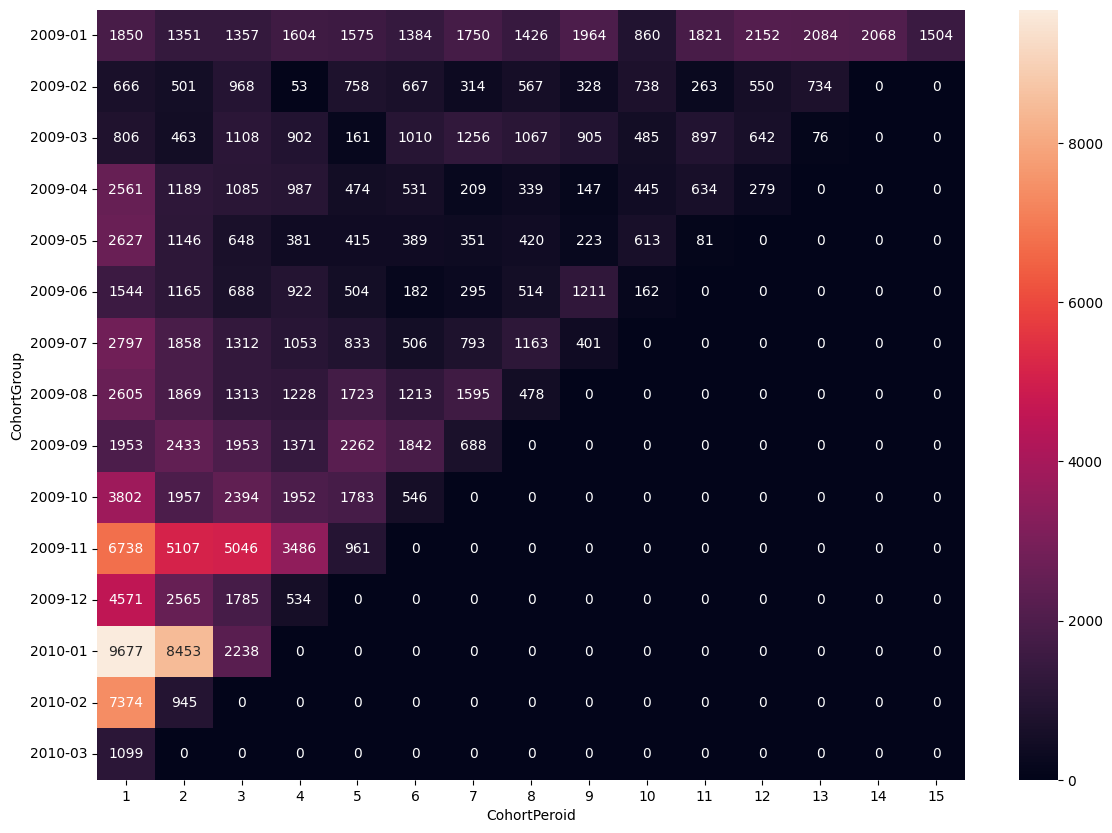

In [ ]:
plt.figure( figsize=( 14, 10))

# mask = retention_df.T.isnull() : True인 구간은 표시하지 않음
data = cohorts['TotalCharges'].unstack(0).T.fillna(0).astype('int')

sns.heatmap( data, annot=True, fmt='0' );
# QnA mask 처리
해석 = '''
    - 수평 :
        - 2009-01 그룹은 매출이 계속 비슷한수준에 유지되고 있음
            - 고객 유지율은 줄어서 어느정도 수렴하고 있지만, 매출을 오히려 상승 혹은 유지중
            - 이 고객들 중에 1인당 주문을 여러건 수행하는 충성도 높은 고객 존재
    - 수직 :
        - 각 그룹의 구매 첫달의 매출이 상승하고 있다
            - 첫그룹 1850 대비 지속적 증가 추세
            - 특정 그룹 2009-11~ 2010-02 그룹은 3~ 4배 정도 수준을 달성
                - 이벤트가 있지 않았을까.. <= 추가 인사이트 정보 필요
    - 대각선
        - 생략
'''
print( 해석 )

## OTT에서 코호트 분석

- 정액제 기반 콘텐츠 소비하는 서비스
    - 최초 소비 시간 정보
    - 소비를 한 기간(50분 시청, 10분 시청)
    - 그룹을 정하기 위한 인터벌 체크
        - raw data부터 계산(이론, 절차등)해서 획득
    

- 데이터
    - 넷플릭스(캐글에서 제공한 데이터)
    - https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies

### 데이터 로드

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

In [ ]:
csv_dir = '/content/drive/MyDrive/데이터분석스쿨2기/share/12.데이터활용및과학방법론-12/vodclickstream_uk_movies_03.csv'
'''
    - datetime : 콘텐츠를 클릭한 시간
    - duration : 소비한 시간, 머문시간, 콘텐츠를 이탈하기까지 걸린 시간(양)
    - title : 콘텐츠명
    - ...
    - user_id : 유저 고유 아이디(해싱처리됨)
'''
df = pd.read_csv( csv_dir, parse_dates=['datetime'] )

# datetime object -> 문자열로 처리됨 -> datetime 형식으로 세팅
# 최초 로드할때 처리
df.dtypes

Unnamed: 0               int64
datetime        datetime64[ns]
duration               float64
title                   object
genres                  object
release_date            object
movie_id                object
user_id                 object
dtype: object

In [ ]:
df.head(3)

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf


- 국내 넷플릭스 상륙 첫 서비스 개시 시점
    - 2016 ~ 2017
        - 정액제 1700원(?)
    - starter의 기준
        - 2023년 기준 2분 소비
        - 넷플릭스 블로그
            - 점검

### 사용 컬럼만 추출

In [ ]:
use_df = df[ ['user_id', 'datetime', 'duration' ] ].copy(True)

display( use_df.head(1) )
use_df.shape

,user_id,datetime,duration
0,1dea19f6fe,2017-01-01 01:15:09,0.0


(671736, 3)

### 시청시간(양)을 기준 표본추출

- 콘텐츠별 시청시간 기준으로 데이터를 추출
    - 10분이상, 30분이상, **50분이상**,...
        - https://www.pdjournal.com/news/articleView.html?idxno=75593
        - 임의로 50분이상 소비한 콘텐츠만 대상으로 진행 (설정)
    - 0분인 데이터는 제거
        - 이 데이터만 모으면 => 실수, 원하지 않은 콘텐츠,.. => 콘테츠 분석

In [ ]:
10530/60/60

2.925

In [ ]:
# 초단위/60 => 분단위
use_df['duration']/60

0            0.000000
1            0.000000
2          175.500000
3            0.816667
4            0.000000
             ...     
671731      14.183333
671732    1519.283333
671733       0.000000
671734       0.000000
671735       0.000000
Name: duration, Length: 671736, dtype: float64

In [ ]:
use_df.shape

(671736, 3)

In [ ]:
# 의미 잇는 데이터를 기준 => 편당 50분이상(설정) 소비된 데이터만 가지고 진행
# 실습 1분
#raw_df = use_df[ use_df['duration']/60 >= 50 ]
# df => df를 추출( .copy(True) 사용 ), 파생변수 생성 => 경고 X
#raw_df = use_df.query( ' duration/60 >= 50' ).copy(True)

# 10분으로 조정한다면
raw_df = use_df.query( ' duration/60 >= 10' ).copy(True)

raw_df.shape

(291157, 3)

In [ ]:
raw_df.head()

,user_id,datetime,duration
2,7cbcc791bf,2017-01-01 15:17:47,10530.0
6,8e1be40e32,2017-01-01 19:43:06,4903.0
8,cff8ea652a,2017-01-01 19:46:24,3845.0
11,759ae2eac9,2017-01-01 20:55:46,6175.0
13,5b1727dc12,2017-01-01 21:33:26,38120.0


In [ ]:
# 데이터 표본상 datetime 최소, 최대값 체크
raw_df.describe()
# 2017-01-01 00:04:26 ~ 2019-06-30 23:42:21
# 데이터는 2년 6개월치 데이터
# 2017(2018, 2019)년도 기준 분기(반기, 년간, ...) 데이터를 기준으로 코호트 그룹 생성
# 2017년도 1/4분기를 대상으로 진행 -> 기업이 2번째 도약을 위해 시작하던 시점(전세계로 진출)

,datetime,duration
count,291157,2.911570e+05
mean,2018-04-19 23:24:08.287350272,7.720358e+04
min,2017-01-01 00:02:21,6.000000e+02
25%,2017-09-14 20:39:43,3.890000e+03
50%,2018-04-09 22:11:24,8.490000e+03
75%,2018-12-09 01:02:39,6.898500e+04
max,2019-06-30 23:42:21,1.823725e+07
std,NaN,2.319751e+05


### 코호트 그룹을 위한 인터벌 계산

- 인터벌(시간 간격)
    - 주기
        - 일별, **주간별(7일)**, 월별, 분기별,...
    - 기준
        - 사내 규정, 콘텐츠 추가 기간
            - 최근 금요일 17시 오픈
                - 국내
                    - 금토일 시청자를 공략 전략
                - 출근않해도 되는 시점
        - 금요일 오픈
            - 금요일 단위로 2편씩 공개
            - 금요일 단위로 전편 공개
- 산출 방식
    - 산출하는 방식의 하나의 샘플 절차
        - 솔류션별로 가이드 제공(amplitude)
    - 절차
        - Core Event(단 설정기간내(2017.1~2017.3, 1/4분기))를 2번이상 수행한 유저 데이터만 대상
            - Core Event -> 콘텐츠 소비
        - first, second core event 체크
            - second - first 시간 계산
        - 누적분포함수 구현
            - 누적합으로 이벤트 시간
            - CDF
        - 80% 지점 체크
            - 시간값 산출 -> 인터벌 사용


#### 기간설정

In [ ]:
# 2017.1~2017.3, 1/4분기 데이터만 추출
# 실습 1분
# query() 뒷 조건식 체크(점검)
df = raw_df.query( ' datetime >= "2017-01-01" and datetime < "2017-04-01" ' ) \
    .loc[ :, ['user_id','datetime']].copy(True)
df.shape

(19040, 2)

In [ ]:
df

,user_id,datetime
2,7cbcc791bf,2017-01-01 15:17:47
6,8e1be40e32,2017-01-01 19:43:06
8,cff8ea652a,2017-01-01 19:46:24
11,759ae2eac9,2017-01-01 20:55:46
13,5b1727dc12,2017-01-01 21:33:26
...,...,...
42959,3243cbbff5,2017-03-31 17:21:41
42960,4e675eec1e,2017-03-31 17:25:40
42965,cc6f094367,2017-03-31 19:09:46
42967,c1a815060d,2017-03-31 19:42:50


#### first, second core event 체크

- 유저별 시청 -> 이벤트
    - 유저가 여려번 진행 -> datetime 대비 최초 시청(이벤트) 시간은 는 다른 값이 된다
    - **유저별로 집계, 최초 시청한 시간값 추출**
        - 시간값들중 가장 작은 값 - min()
    - 컬럼명 first_event(혹은 watching) 세팅

- first_event

In [ ]:
# 실습 2분
df.groupby('user_id')['datetime'].min()
# 데이터 5672 => 유저수도 5672
# 원데이터 15135 => 모든 유저의 raw 데이터에 'first_event' 컬럼 추가

user_id
0005d9a8f4   2017-01-23 15:03:37
0006b97ace   2017-02-11 20:42:50
0008c31833   2017-03-11 00:18:26
001991be8a   2017-01-06 09:58:34
00234bc910   2017-03-09 17:10:35
                     ...        
ffbac463b9   2017-03-15 12:58:09
ffc4931aac   2017-03-03 23:22:37
ffcf7e4e01   2017-03-21 01:21:07
fff616aa0e   2017-02-23 20:37:07
fff6531436   2017-01-19 23:00:30
Name: datetime, Length: 6249, dtype: datetime64[ns]

In [ ]:
# 특정 그룹에 동일한 내용을 적용 -> 그룹내 숫자만큼 동일하게 처리
df['first_event'] = df.groupby('user_id')['datetime'].transform('min')
df.head(2)
# 두번째 유저는 다른 시점에 첫번째 시청을 50분이상 진행하였다

,user_id,datetime,first_event
2,7cbcc791bf,2017-01-01 15:17:47,2017-01-01 15:17:47
6,8e1be40e32,2017-01-01 19:43:06,2017-01-01 03:08:56


- second_event

In [ ]:
# df 상의 raw 데이터는 특정 유저가 특정 콘텐츠를 소비
# -> raw 관점, 유저를 배제하고 고려 -> second event
# datetime를 second_event 변경 처리
df.rename( columns={'datetime':'second_event'}, inplace=True )
df

# 데이터는 first, second가 동일한 값을 가진 데이터도 존재

,user_id,second_event,first_event
2,7cbcc791bf,2017-01-01 15:17:47,2017-01-01 15:17:47
6,8e1be40e32,2017-01-01 19:43:06,2017-01-01 03:08:56
8,cff8ea652a,2017-01-01 19:46:24,2017-01-01 19:46:24
11,759ae2eac9,2017-01-01 20:55:46,2017-01-01 20:55:46
13,5b1727dc12,2017-01-01 21:33:26,2017-01-01 00:38:22
...,...,...,...
42959,3243cbbff5,2017-03-31 17:21:41,2017-03-31 17:21:41
42960,4e675eec1e,2017-03-31 17:25:40,2017-02-07 18:32:06
42965,cc6f094367,2017-03-31 19:09:46,2017-03-30 18:52:53
42967,c1a815060d,2017-03-31 19:42:50,2017-03-11 22:17:45


In [ ]:
# (s-f) 차이가 나는 데이터만 활용 => 값이 다른 데이터만 대상
# 유저수만큼 제거됨 => 유저별 최초 시청 기록 데이터는 모두 삭제된것임
df.query( ' first_event != second_event ' ).shape

(12791, 3)

In [ ]:
df_sub = df.query( ' first_event != second_event ' )
df_sub.head()

,user_id,second_event,first_event
6,8e1be40e32,2017-01-01 19:43:06,2017-01-01 03:08:56
13,5b1727dc12,2017-01-01 21:33:26,2017-01-01 00:38:22
33,7cbcc791bf,2017-01-01 18:13:17,2017-01-01 15:17:47
36,177868f4f8,2017-01-01 20:22:10,2017-01-01 07:40:37
39,3142b4c730,2017-01-01 23:47:40,2017-01-01 21:37:41


In [ ]:
# 사용자별 데이터가 몇개 존재하는가?
# 사용자별 기간내 시청개수 체크 -> 최초는 삭제가 된 기록
df_sub.groupby('user_id').count()
# 특정 기간내에 시청기록 수 -> 기준을 부여한다면 시청기록이 특정 회수 이상인 데이터만 대상 진행 가능함

,second_event,first_event
user_id,,
0008c31833,2,2
0029f6bb1e,26,26
003e4ea440,2,2
004346d453,7,7
005ca94b66,1,1
...,...,...
ffbac463b9,1,1
ffc4931aac,3,3
ffcf7e4e01,2,2


In [ ]:
# 데이터 정렬
# user_id, second_event 순으로 정렬
df_sub = df_sub.sort_values(['user_id','second_event']) # 실습 1분
df_sub.head()
# 동일 유저 기준 -> second_event 확인 가능함

,user_id,second_event,first_event
26322,0008c31833,2017-03-11 00:28:26,2017-03-11 00:18:26
26970,0008c31833,2017-03-12 00:17:42,2017-03-11 00:18:26
6594,0029f6bb1e,2017-01-17 19:53:23,2017-01-17 19:36:05
6615,0029f6bb1e,2017-01-17 23:17:05,2017-01-17 19:36:05
6721,0029f6bb1e,2017-01-18 18:22:35,2017-01-17 19:36:05


In [ ]:
'''
    - 0029f6bb1e 유저 대상
    - 시청 -> 이벤트
    - 1-f : 2017-01-17 19:53:23
    - 2-s : 2017-01-17 23:17:05
    - 3-t : 2017-01-18 18:22:35
    - second_event 컬럼 기준 기준
        - 각 유저별 second_event값들중 가장 작은값 -> 진짜 second_event
'''
# 유저 그룹별 second_event의 최초값을 추출
# -> 그 raw data는 진짜 f-s 데이터를 가지고 있음
df_sub.groupby('user_id').first()
# 데이터수 => 2875건 => 대상유저

,second_event,first_event
user_id,,
0008c31833,2017-03-11 00:28:26,2017-03-11 00:18:26
0029f6bb1e,2017-01-17 19:53:23,2017-01-17 19:36:05
003e4ea440,2017-03-27 16:31:57,2017-03-04 22:15:38
004346d453,2017-03-19 14:03:28,2017-03-19 00:18:44
005ca94b66,2017-03-22 18:41:33,2017-03-09 21:16:14
...,...,...
ffbac463b9,2017-03-15 14:18:09,2017-03-15 12:58:09
ffc4931aac,2017-03-18 17:58:41,2017-03-03 23:22:37
ffcf7e4e01,2017-03-29 00:33:42,2017-03-21 01:21:07


In [ ]:
# user_id => 컬럼으로 이동, index => 0, 1, 2..  자동세팅
df_sub = df_sub.groupby('user_id').first().reset_index(drop=False)
df_sub

,user_id,second_event,first_event
0,0008c31833,2017-03-11 00:28:26,2017-03-11 00:18:26
1,0029f6bb1e,2017-01-17 19:53:23,2017-01-17 19:36:05
2,003e4ea440,2017-03-27 16:31:57,2017-03-04 22:15:38
3,004346d453,2017-03-19 14:03:28,2017-03-19 00:18:44
4,005ca94b66,2017-03-22 18:41:33,2017-03-09 21:16:14
...,...,...,...
3398,ffbac463b9,2017-03-15 14:18:09,2017-03-15 12:58:09
3399,ffc4931aac,2017-03-18 17:58:41,2017-03-03 23:22:37
3400,ffcf7e4e01,2017-03-29 00:33:42,2017-03-21 01:21:07
3401,fff616aa0e,2017-02-23 22:36:12,2017-02-23 20:37:07


#### 누적분포함수 구현

- CDF( Cumulative Distribution Function )    

In [ ]:
# dt <-> loc(권장)
# idt <-> iloc(권장)
# 표현이 간결하다, 대량의 데이터가면 고민
# 이벤트간 차수(days 기준)
(df_sub['second_event'] - df_sub['first_event']).dt.days

0        0
1        0
2       22
3        0
4       12
        ..
3398     0
3399    14
3400     7
3401     0
3402     3
Length: 3403, dtype: int64

In [ ]:
def cal_cohort_interval( df ):
    # 1. 차수 계산 -> se - fir 차이 일수 계산
    df['diff_day'] =(df_sub['second_event'] - df_sub['first_event']).dt.days
    print( df.head(2))

    # 2. diff_day값이 일치하는 유저수 집계
    count = df.groupby('diff_day').count().iloc[:, 0]
    '''
            diff_day
        0     1110
        1      338
    '''

    # 3, 전체유저에서 diff_day별 유저 비중 계산
    pdf = [ value/sum(count) for value in count ]
    # ex) diff_day값이 1110인유저는 전체유저(표본기준) 0.386 비율을 차지한다
    print( '\n', pdf )

    # 4. cdf 계산
    cdf = np.cumsum( pdf )
    return cdf

cdf = cal_cohort_interval( df_sub )
# 마지막에는 1이 나옴
print( cdf )

      user_id        second_event         first_event  diff_day
0  0008c31833 2017-03-11 00:28:26 2017-03-11 00:18:26         0
1  0029f6bb1e 2017-01-17 19:53:23 2017-01-17 19:36:05         0

 [0.45342344989714956, 0.10285042609462239, 0.06582427270055834, 0.040846312077578606, 0.044372612400822804, 0.03232441962973846, 0.03967087863649721, 0.02850426094622392, 0.01792535997649133, 0.017043784895680283, 0.012342051131354687, 0.014399059653247136, 0.014399059653247136, 0.011460476050543638, 0.015574493094328533, 0.008521892447840141, 0.007640317367029092, 0.007934175727299441, 0.008521892447840141, 0.007934175727299441, 0.0073464590067587425, 0.006464883925947693, 0.005583308845136644, 0.003820158683514546, 0.002057008521892448, 0.0023508668821627977, 0.0011754334410813989, 0.002057008521892448, 0.003526300323244196, 0.001763150161622098, 0.0014692918013517484, 0.0014692918013517484, 0.002057008521892448, 0.0002938583602703497, 0.0014692918013517484, 0.000881575080811049, 0.00088157508

#### 80% 지점 체크후 인터벌 산출

In [ ]:
# cdf의 80% 지점에 일치하는 day를 기준으로 코호트 인터벌 계산
# 시청시간을 몇분 기준으로 잡고 분석을 시작하는가? => 여러 논문, 회사 특징등등 고려

# 50분기준, 2017년도 1/4분기 기준 영국영화 시청자 유저들중
# 코호트 그룹 구성을 위한 인터벌 단위는 : 주말기준 8일 차이 -> 8단위로 환산 진행
# QnA 8일을 인터벌로 잡고 진행하는 부분

# 10분기준, 2017년도 1/4분기 기준 영국영화 시청자 유저들중
# 코호트 그룹 구성을 위한 인터벌 단위는 : 주말기준 7일 차이 -> 7단위로 환산 진행
TERM_DAY = np.abs(cdf - 0.8).argmin()
TERM_DAY

7

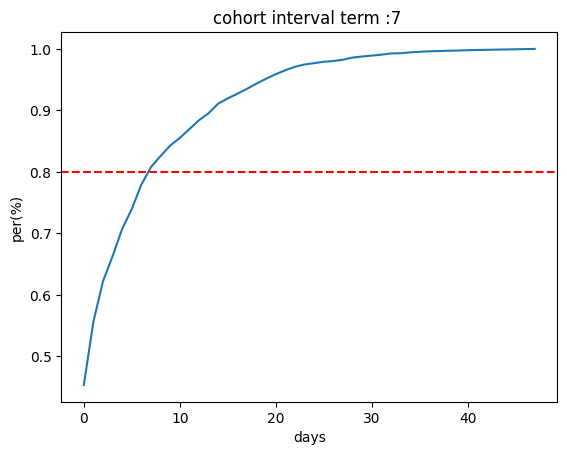

In [ ]:
# 시각화 확인
plt.plot( cdf )
# 80% 지점 수평선
plt.axhline( y=0.8, color='red', linestyle='--')

plt.title(f'cohort interval term :{TERM_DAY} ')
plt.xlabel('days')
plt.ylabel('per(%)')

'''
- 해석
    - 10분기준, 2017년도 1/4분기 기준 영국영화 시청자 유저들중
    - 약 80% 유저들이 콘텐츠를 10분이상 본날로부터 7일째 되는날
     다시 콘텐츠를 10분이상 소비하였다
    - 코호트 그룹의 단위(인터벌) 7일 간격으로 구성한다
'''

plt.show()

### 코호트 데이터 구성

In [ ]:
df_sub2 = raw_df.query( ' datetime >= "2017-01-01" and datetime < "2017-04-01" ' ) \
    .loc[ :, ['user_id','datetime']].copy(True)
df_sub2.shape

(19040, 2)

In [ ]:
df_sub2.head(2)

,user_id,datetime
2,7cbcc791bf,2017-01-01 15:17:47
6,8e1be40e32,2017-01-01 19:43:06


In [ ]:
df_sub2.dtypes

user_id             object
datetime    datetime64[ns]
dtype: object

In [ ]:
# datetime 기준 7일 이전의 날짜로부터 7일이 경과된 시점을 그룹의 기준
# 2017-01-01 15:17:47 -> 7일이전 2016-12-26 15:17:47 => 코호트 그룹 기준
# 데이터 기준 7일 이전을 코호트 그룹의 이름,기준값으로 사용 => 7일간격으로 데이터를 구성
def cal_ret_mat( df ):
    # 2017-01-01를 최초값으로 사용하기 위함
    # 코호트 그룹명은 2016-12-26, 2017-01-02, 2017-01-09, 2017-01-16,..

    # 1. 단위 조정 : 2017-01-01 15:17:47 => 2017-01-01
    #    년월일 시분초 => 년월일, 파생변수 'date', 필요없는 'datetime' 제거
    # 실습 : 1분, apply()가능, 아래처럼 표현
    df['date'] = df['datetime'].dt.date # 데이터는 문자열로 구성되어 있음
    df = df.drop('datetime', axis=True)
    #print( df.head(2) )
    #print( df.dtypes )

    # 2. date기준 TERM_DAY(7) 만큼 시간을 뒤로 돌려서 날짜정보획득
    #    df['date'] - 7days
    # QnA 직접 날짜차이값(7, 8, 10, 20일등)을 넣어서 계산해보는 방식 도출
    # 7일 -> 요일기준 주간단위 활용해서 차감
    df['date'] = df['date'] - pd.to_timedelta( \
                    pd.to_datetime(df['date']).dt.dayofweek, unit='d' )
    df['date'] = pd.to_datetime( df['date'] )
    #print( '\n', df.head() )


    # 3. 사용자별 날짜->
    # 특정유저 2016-12-26, 2016-12-27, 2017-01-01, .... => 최초 시청한날 => min
    # 사용자별 데이터를 집계 ->
    df['cohort'] = df.groupby('user_id')['date'].transform('min')
    #print( '\n', df[300:310] )


    # 4. 코호트 그룹(cohort) 내에서 날짜별(date) 유저수 계산
    # 파생변수(cnt) 생성
    cohort_df = df.groupby(['cohort', 'date']).agg(
            cnt=('user_id','nunique')
        ).reset_index(drop=False)
    #print( cohort_df)

    # 5. D+7(1), D+14(2), ..  코호트그룹과화 날짜사이에 interval 크기를 계산
    # (date-cohort):diff/TERM_DAY => 0, 1, 2, 3, ....
    cohort_df['diff'] = [ math.floor( d )
            for d in ( cohort_df['date']-cohort_df['cohort'] ).dt.days / TERM_DAY
        ]
    #print( (cohort_df['date']-cohort_df['cohort']).dt.days/TERM_DAY )
    #print( cohort_df.head())

    # 6. cohort_df => 전통적 코호트 차트 형태로 데이터 구성
    # 실습 3분
    cohort_df_pv = cohort_df.pivot_table(index='cohort',
                                         columns='diff', values='cnt')
    #print( cohort_df_pv )

    # 7. 8번 구현을 위해 코호트별 총인원(중복없이) 획득
    cohort_per_users = df.groupby('cohort').agg(
                            cnt=('user_id', 'nunique') )['cnt']
    #  cohort_df_pv의 첫번째 컬럼값과 동일함
    #print( cohort_per_users )

    # 8. cohort_df_pv/(코호트 그룹별 총인원)
    # DataFrame/Series 오류 => cohort_df_pv.divide( Series, axis = 0 )
    return cohort_df_pv.divide( cohort_per_users, axis = 0)


ret_mat = cal_ret_mat( df_sub2.copy(True) )
print( '\n 최종 결과', ret_mat )


 최종 결과 diff         0         1         2         3         4         5         6   \
cohort                                                                        
2016-12-26  1.0  0.542169  0.319277  0.222892  0.222892  0.138554  0.024096   
2017-01-02  1.0  0.292174  0.208696  0.154783  0.104348  0.045217  0.012174   
2017-01-09  1.0  0.275964  0.163205  0.127596  0.068249  0.023739  0.011869   
2017-01-16  1.0  0.229572  0.132296  0.066148  0.031128  0.023346  0.003891   
2017-01-23  1.0  0.201835  0.128440  0.073394  0.064220  0.050459  0.041284   
2017-01-30  1.0  0.182979  0.148936  0.127660  0.089362  0.068085  0.046809   
2017-02-06  1.0  0.308357  0.276657  0.201729  0.193084  0.170029  0.144092   
2017-02-13  1.0  0.279874  0.210692  0.154088  0.154088  0.132075  0.072327   
2017-02-20  1.0  0.259494  0.148734  0.088608  0.079114  0.063291       NaN   
2017-02-27  1.0  0.284450  0.213654  0.203540  0.139064       NaN       NaN   
2017-03-06  1.0  0.254926  0.203202  0.15024

<ipython-input-229-c682e8022e01>:20: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  df['date'] = df['date'] - pd.to_timedelta( \


In [ ]:
ret_mat

diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2016-12-26,1.0,0.542169,0.319277,0.222892,0.222892,0.138554,0.024096,0.012048,0.018072,0.006024,0.006024,0.006024,0.006024,0.006024
2017-01-02,1.0,0.292174,0.208696,0.154783,0.104348,0.045217,0.012174,0.008696,0.006957,0.005217,0.006957,0.005217,0.005217,NaN
2017-01-09,1.0,0.275964,0.163205,0.127596,0.068249,0.023739,0.011869,0.005935,0.008902,0.005935,0.005935,0.002967,NaN,NaN
2017-01-16,1.0,0.229572,0.132296,0.066148,0.031128,0.023346,0.003891,0.007782,0.011673,0.003891,0.011673,NaN,NaN,NaN
2017-01-23,1.0,0.201835,0.128440,0.073394,0.064220,0.050459,0.041284,0.027523,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-30,1.0,0.182979,0.148936,0.127660,0.089362,0.068085,0.046809,0.029787,0.025532,NaN,NaN,NaN,NaN,NaN
2017-02-06,1.0,0.308357,0.276657,0.201729,0.193084,0.170029,0.144092,0.109510,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-13,1.0,0.279874,0.210692,0.154088,0.154088,0.132075,0.072327,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-20,1.0,0.259494,0.148734,0.088608,0.079114,0.063291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


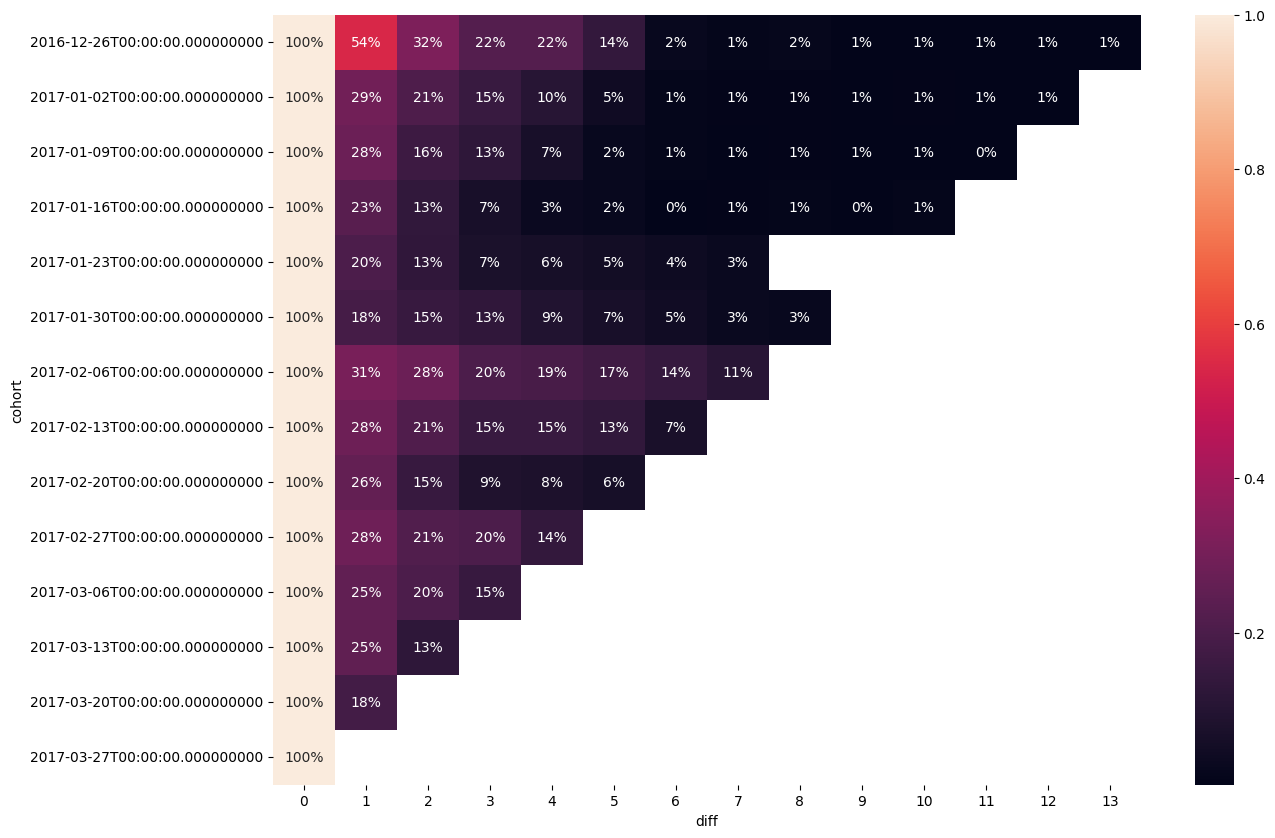

In [ ]:
plt.figure( figsize=( 14, 10))
'''
    - 대부분 코호트 그룹들은 3개월 정도 지나면 10% 안쪽으로 retention이 유지됨
    - 2017-01-23 그룹은 56(day)차 이후로는 더이상 시청하고 있지 않다
        - 정액제 해지 여부까지 참고 필요
    - 2017-02-06 그룹은 비교적 완만하게 리텐션이 줄고 있다
    - 초기 그룹들은 1% 수준으로 리텐션이 유지되고 있다(수렴한것으로 보임)
'''
sns.heatmap( ret_mat, annot=True, fmt='.0%' );

In [ ]:
# 리텐션 평균값 기준 시각화
ret_mat_avg_per = ret_mat.mean(axis=0)*100
ret_mat_avg_per

diff
0     100.000000
1      27.246462
2      18.997470
3      14.278940
4      11.455490
5       7.942178
6       4.456787
7       2.875442
8       1.422719
9       0.526681
10      0.764712
11      0.473628
12      0.562074
13      0.602410
dtype: float64

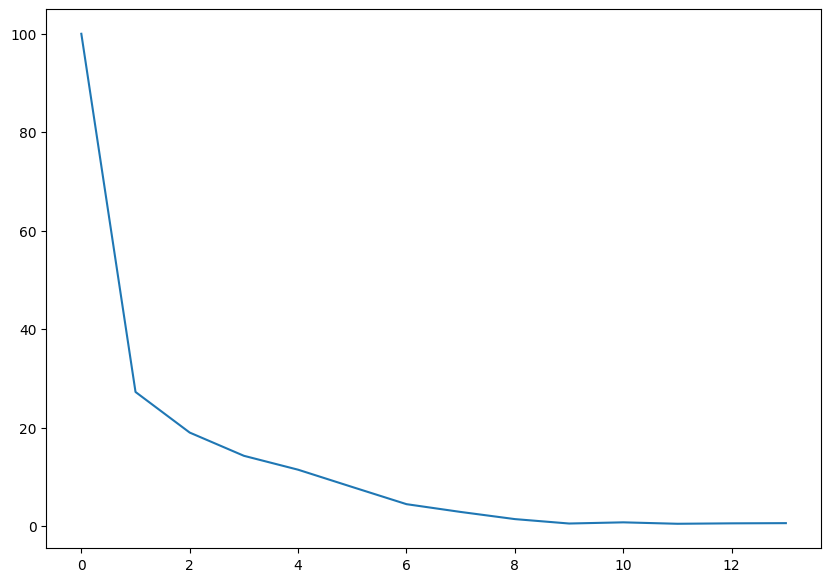

In [ ]:
plt.figure( figsize=(10, 7) )
# 평균적으로 2017-01-01 ~ 2017-03-31 사이 기간동안 영국 영화를 시청한
# 유저를 대상으로 리텐션 값을 평균적으로 분기기준으로 시각화
plt.plot( range(0, len(ret_mat_avg_per)), ret_mat_avg_per )

plt.show()